In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import sys
sys.path.append('/drive/My Drive/ML_Ultrasound_Project/UROPdata')

In [56]:
!pwd

/content


Trying to access deprecated config `openmp`. Using `language` instead


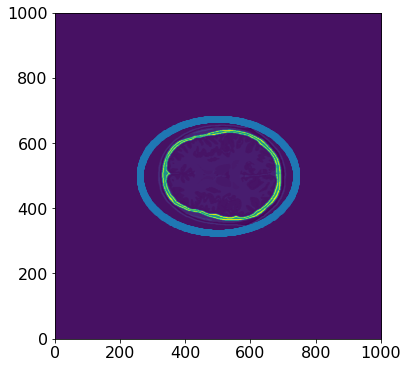

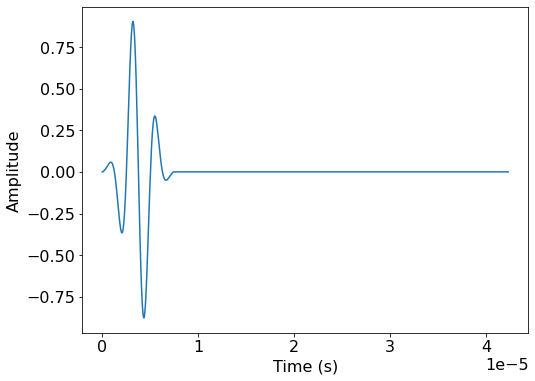

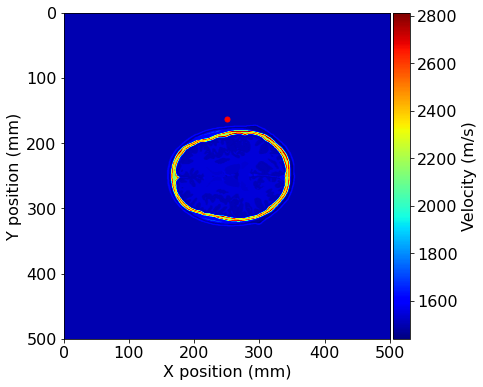

Operator `Kernel` run in 1.53 s


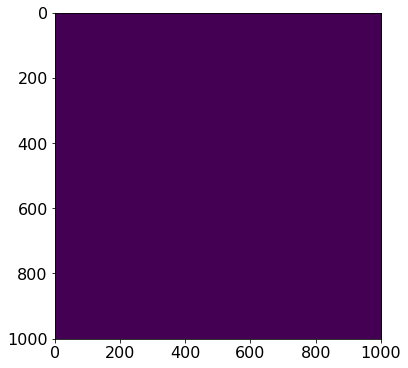

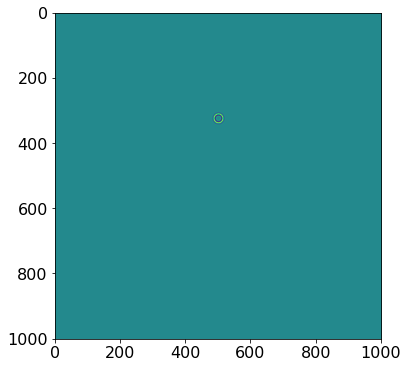

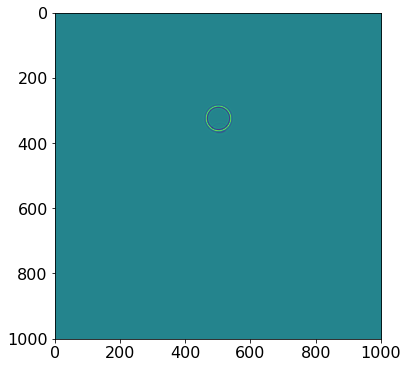

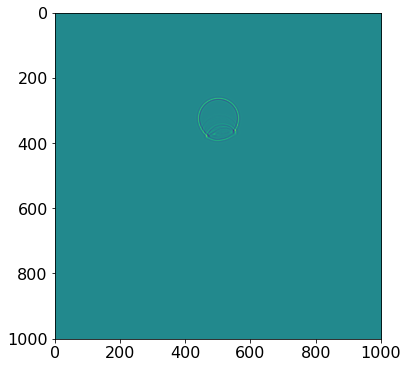

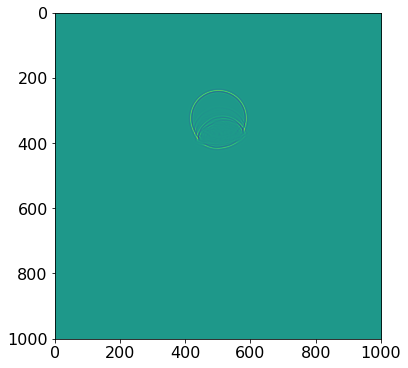

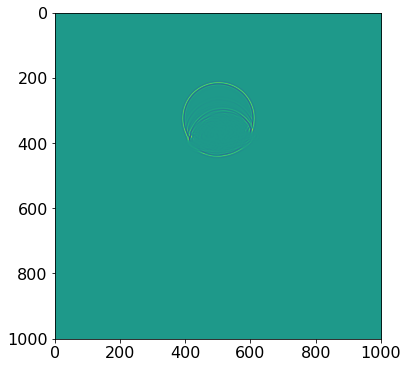

In [58]:
# !pip install git+https://github.com/devitocodes/devito.git
# !pip install sympy==1.5.1
# !pip install numpy==1.17.0

import numpy as np
import matplotlib.pyplot as plt

import devito
from sympy import Symbol
from devito import Operator
from devito import Eq, solve
from devito import TimeFunction

from medical.plotting import plot_shotrecord, plot_velocity
from medical.source import ToneBurstSource, Receiver
from medical.source import TimeAxis
from medical.model import Model

# devito.parameters.configuration['dse'] = 'advanced'
# devito.parameters.configuration['dle'] = 'speculative'
devito.parameters.configuration['openmp'] = True
devito.parameters.configuration['mpi'] = False

# By changing the src_index you'll be selecting a different source coordinate from the different 512 that have been created
# By changing the model type to water, skull or full you'll get different background mediums
# The cutting box has dimensions of (485, 355) in this case. This cannot change
# The cutting box is centred in the medium
# The complete medium is currently (1001, 1001) but you will have to make this bigger if you need to in order to
# make sure that the wavefield does not come back into the cutting box after hitting the edges of the complete medium

src_index = 256  # From 0 to 512
model_type = 'full'  # water, skull or full


def create_eliptic_array(n_sources, boundary_offset, dx, shape):
    a = (shape[1] / 2)
    b = (shape[0] / 2)

    pos = np.empty((2, n_sources), dtype=np.float32)
    angle = np.zeros((n_sources))
    for idx in range(n_sources):
        angle[idx] = ((idx) * 360.0 / n_sources) * 2 * np.pi / 360.0  # transducer angle
        pos[1, idx] = (a * np.cos(angle[idx]) + shape[1] / 2)  # spherical equation of ellipse
        pos[0, idx] = (b * np.sin(angle[idx]) + shape[0] / 2)  # spherical equation of ellipse

    pos[0, :] += boundary_offset[0]
    pos[1, :] += boundary_offset[1]
    pos *= dx
    # np.array((np.divide(grid[0] ** 2, major_ax ** 2) + np.divide(grid[1] ** 2, minor_ax ** 2)) < 1, dtype=np.float32)
    return pos


# Load different types of background models
if model_type == 'water':
    model = np.ones((480, 350)) * 1500.

elif model_type == 'skull':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-ExactSkull.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

elif model_type == 'full':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-TrueVp.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()


# Define a physical size
shape = (1001, 1001)            # Number of grid point (nx, nz) - CHANGE THIS FOR THE MEDIUM SIZE
spacing = (0.5e-3, 0.5e-3)      # Grid spacing in m.
origin = (0., 0.)               # What is the location of the top left corner. This is necessary to define
                                # the absolute location of the source and receivers

# Define a velocity profile. The velocity is in m/s
diff_x = shape[0] - model.shape[0]
diff_y = shape[1] - model.shape[1]
offset_x = int(np.floor(diff_x/2))
offset_y = int(np.floor(diff_y/2))

model = np.pad(model,
               ((int(np.floor(diff_x/2)), int(np.ceil(diff_x/2))), (int(np.floor(diff_y/2)), int(np.ceil(diff_y/2)))),
               'edge')

plt.imshow(np.transpose(model), origin='lower')

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=model, origin=origin, shape=shape, spacing=spacing, space_order=4, nbpml=0)

t0 = 0.                 # Simulation starts a t=0
num = 530              # Simulation last number of time steps - CHANGE THIS FOR THE AMOUNT OF TIMESTEPS
dt = 0.08e-6            # Time step from model grid spacing

time_range = TimeAxis(start=t0, num=num, step=dt)

f0 = 0.40e6  # Source peak frequency is 400kHz
src = ToneBurstSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)

# First, position source centrally in all dimensions
src_positions = create_eliptic_array(512, (offset_x, offset_y), spacing[0], (480, 350))
src.coordinates.data[0, :] = src_positions[:, src_index]

plt.scatter(src_positions[0, :]/spacing[0], src_positions[1, :]/spacing[1])
plt.show()

# We can plot the time signature to see the wavelet
src.show()

# We can now show the source and receivers within our domain:
# Red dot: Source location
plot_velocity(model, source=src.coordinates.data)

# In order to represent the wavefield u and the square slowness we need symbolic objects
# corresponding to time-space-varying field (u, TimeFunction) and
# space-varying field (m, Function)

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4, save=num)

# Create a temporary symbol for H to avoid expensive sympy solve
H = Symbol('H')

# Define PDE
eq = model.m * u.dt2 - H

# Solve the symbolic equation for the field to be updated
eq_time = solve(eq, u.forward)

# Get the spacial FD
biharmonic = u.biharmonic(1/model.m)
laplacian = u.laplace + dt**2/12 * biharmonic

# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as
# a time marching updating equation known as a stencil using customized SymPy functions
stencil = Eq(u.forward, eq_time.subs({H: laplacian}))

# Finally we define the source injection function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Execute the operator
u.data.fill(0.)
op = Operator([stencil] + src_term, subs=model.spacing_map)
op(dt=dt)  # AFTER THIS LINE u.data HAS THE WAVEFIELD AT ALL TIMESTEPS WITH SHAPE (num, nx, ny)

# Plot some results
for t in range(0, num, 100):
    # The wavefield that we have solved for is now stored in 'u.data', which is a numpy array of
    # shape (num time steps, nx, ny)
    plt.imshow(np.transpose(u.data[t]))
    plt.show()





In [59]:
# Save the data numpy array u.data as compressed form TO TEMP FOLDER CONTENT SO YOU CAN THEN DOWNLOAD TO LOCAL MACHINE
#NOTE: this was after crashing the ability to mount google drive 
np.savez_compressed('/content/basedata', a=u.data)

In [60]:
# Save the data numpy array u.data as compressed form
np.savez_compressed('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/basedata', a=u.data)

In [61]:
print(u.data)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
